In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from ConvAutoencoder import Encoder, Decoder
from actor_critic_rnn import ActorCriticRNN, update, compute_reward
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Dati simulati per esempio
frames = torch.load("frames_sinus.pt")  # Carica il dataset salvato
frames = frames.float() / 255.0  # Normalizza tra [0, 1]
frames = frames.permute(0, 3, 1, 2)  # Cambia dimensione a (N, C, H, W)

# Dimensioni del dataset
#dataset_size = len(frames)
#train_size = int(0.8 * dataset_size)  # 80% per il training
#test_size = dataset_size - train_size  # 20% per il test

########## TOY MODEL ##########
train_size = 500
test_size = 100


# Divisione del dataset preservando l'ordine
train_frames = frames[:train_size]
test_frames = frames[train_size:test_size + train_size]

# DataLoader
batch_size = 8
train_loader = DataLoader(train_frames, batch_size=batch_size, shuffle=False)  # Shuffle disattivato
test_loader = DataLoader(test_frames, batch_size=batch_size, shuffle=False)

# Stampa informazioni
#print(f"Dataset totale: {dataset_size} esempi")
print(f"Training set: {train_size} esempi")
print(f"Test set: {test_size} esempi")

# Parametri
latent_dim = 8192 # 64x64 pixels per frame
action_dim = 8192  # Dimensione delle azioni
gamma = 0.99
learning_rate = 1e-3

# Modello Actor-Critic
actor_critic_rnn = ActorCriticRNN(latent_dim, action_dim)
optimizer = optim.Adam(actor_critic_rnn.parameters(), lr=learning_rate)

# Encoder pre-addestrato
encoder = Encoder()
encoder.load_state_dict(torch.load('encoder.pth'))
encoder.eval()

# Training loop
num_epochs = 25
epoch_losses = []
epoch_actor_losses = []
epoch_critic_losses = []
epoch_rewards = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_actor_loss = 0
    epoch_critic_loss = 0
    epoch_reward = 0
    
    for i in range(len(train_frames) - 1):
        # Seleziona una finestra di immagini
        state = train_frames[i].unsqueeze(0)
        real_next_state = train_frames[i + 1].unsqueeze(0)
        
        if i == 0:
            previous_action = torch.zeros(1, action_dim).unsqueeze(0)
        else:
            previous_action, _ = actor_critic_rnn(latent_state)

        # Ottieni la rappresentazione latente
        with torch.no_grad():
            latent_state = encoder(state)  # [1, latent_dim]
            #print(f"Latent state shape (after encoder): {latent_state.shape}")

            latent_state = latent_state.view(latent_state.size(0), -1).unsqueeze(1)  # [batch_size=1, seq_len=1, latent_dim]
            #print(f"Latent state shape (after flattening): {latent_state.shape}")

            real_next_latent_state = encoder(real_next_state)  # [1, latent_dim]
            #print(f"Latent next state shape (after encoder): {real_next_latent_state.shape}")

            real_next_latent_state = real_next_latent_state.view(real_next_latent_state.size(0), -1).unsqueeze(1)  # [batch_size=1, seq_len=1, latent_dim]
            #print(f"Latent next state shape (after flattening): {real_next_latent_state.shape}")

        loss, actor_loss, critic_loss, reward = update(actor_critic_rnn, optimizer, latent_state, real_next_latent_state, previous_action, gamma)

        # Accumula i risultati per l'epoca
        epoch_loss += loss
        epoch_actor_loss += actor_loss
        epoch_critic_loss += critic_loss
        epoch_reward += reward

    # Salva le medie dell'epoca
    epoch_losses.append(epoch_loss / (len(train_frames) - 1))
    epoch_actor_losses.append(epoch_actor_loss / (len(train_frames) - 1))
    epoch_critic_losses.append(epoch_critic_loss / (len(train_frames) - 1))
    epoch_rewards.append(epoch_reward / (len(train_frames) - 1))

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Critic_loss: {epoch_critic_loss:.4f}, Actor_loss: {epoch_actor_loss:.4f}, Reward: {epoch_reward:.4f}")


Training set: 500 esempi
Test set: 100 esempi


/Users/edoardozappia/opt/anaconda3/envs/mujoco-env/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 8192])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/25, Loss: 1.4286, Critic_loss: 0.0776, Actor_loss: 1.3509, Reward: -2.0658
Epoch 2/25, Loss: 0.0491, Critic_loss: 0.0414, Actor_loss: 0.0077, Reward: -0.9984
Epoch 3/25, Loss: 0.0463, Critic_loss: 0.0420, Actor_loss: 0.0043, Reward: -1.0866
Epoch 4/25, Loss: 0.0448, Critic_loss: 0.0423, Actor_loss: 0.0025, Reward: -1.0860
Epoch 5/25, Loss: 0.0441, Critic_loss: 0.0424, Actor_loss: 0.0017, Reward: -1.0821
Epoch 6/25, Loss: 0.0439, Critic_loss: 0.0424, Actor_loss: 0.0015, Reward: -1.0933
Epoch 7/25, Loss: 0.0438, Critic_loss: 0.0423, Actor_loss: 0.0014, Reward: -1.0993
Epoch 8/25, Loss: 0.0433, Critic_loss: 0.0423, Actor_loss: 0.0011, Reward: -1.0819
Epoch 9/25, Loss: 0.0433, Critic_loss: 0.0422, Actor_loss: 0.0011, Reward: -1.0888
Epoch 10/25, Loss: 0.0430, Critic_loss: 0.0422, Actor_loss: 0.0008, Reward: -1.0396
Epoch 11/25, Loss: 0.0431, Critic_loss: 0.0421, Actor_loss: 0.0010, Reward: -1.0562
Epoch 12/25, Loss: 0.0432, Critic_loss: 0.0420, Actor_loss: 0.0012, Reward: -1.0242
E

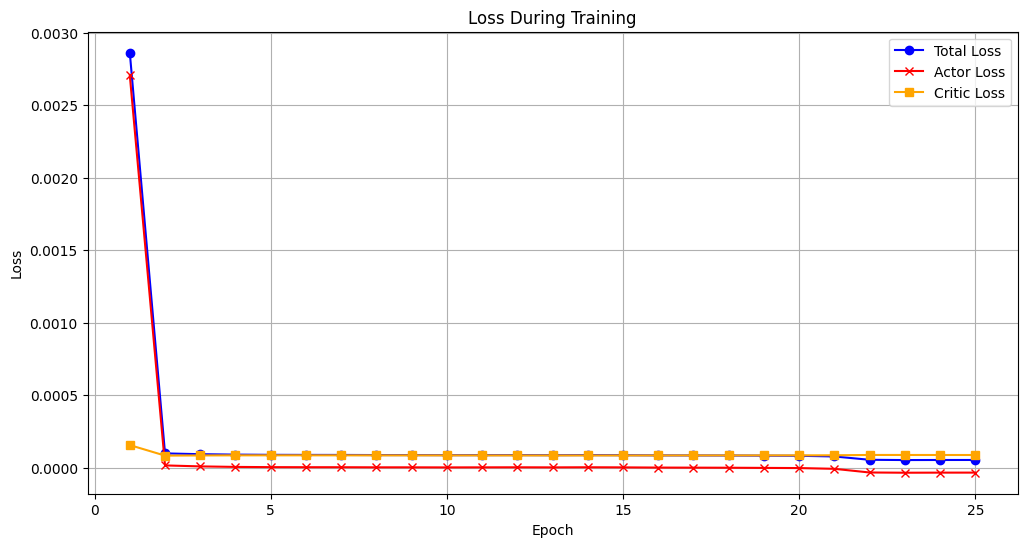

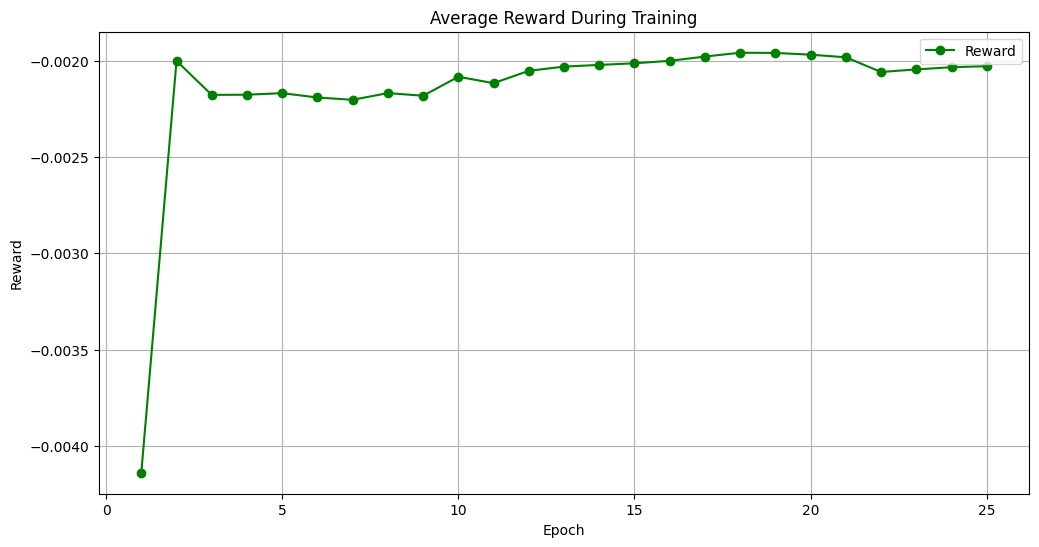

In [3]:
# Grafico delle Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Total Loss', color='blue')
plt.plot(range(1, num_epochs + 1), epoch_actor_losses, marker='x', label='Actor Loss', color='red')
plt.plot(range(1, num_epochs + 1), epoch_critic_losses, marker='s', label='Critic Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Grafico dei Reward
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), epoch_rewards, marker='o', label='Reward', color='green')
plt.title('Average Reward During Training')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# Salva i pesi del modello Actor-Critic RNN
torch.save(actor_critic_rnn.state_dict(), "actor_critic_rnn.pth")

print("Modello Actor-Critic RNN salvato correttamente.")

Modello Actor-Critic RNN salvato correttamente.


In [4]:
# Metti il modello in modalità valutazione
actor_critic_rnn.eval()
encoder.eval()

# Liste per memorizzare le loss
test_losses = []
real_states_list = []
predicted_states_list = []
test_rewards = []

# Calcola la loss sui dati di test
with torch.no_grad():
    for i in range(len(test_frames) - 1):
        # Seleziona una finestra di immagini
        state_frame = test_frames[i].unsqueeze(0)
        real_next_frame = test_frames[i + 1].unsqueeze(0)

        # Ottieni la rappresentazione latente dalla finestra di immagini
        latent_state = encoder(state_frame)  # [window_size, latent_dim]
        latent_state = latent_state.view(latent_state.size(0), -1).unsqueeze(1)  # Aggiunge dimensione batch [1, window_size, latent_dim]
        
        real_next_latent_state = encoder(real_next_frame)  # Stato reale successivo [latent_dim]
        real_next_latent_state = real_next_latent_state.view(real_next_latent_state.size(0), -1).unsqueeze(1)

        action, _ = actor_critic_rnn(latent_state)

        # Usa la funzione update per calcolare le metriche
        loss, actor_loss, critic_loss, reward = update(actor_critic_rnn, None, latent_state, real_next_latent_state, gamma=0.99)

        # Salva la loss totale
        test_losses.append(loss)
        test_rewards.append(reward)

        # Salva i primi 5 esempi
        if (i == 20 or i == 40 or i == 60 or i == 80 or i == 0):
            real_states_list.append(real_next_latent_state.cpu().numpy())
            predicted_states_list.append((latent_state + action).cpu().numpy())

# Calcola la perdita media
mean_test_loss = sum(test_losses) / len(test_losses)
print(f"Mean Test Loss: {mean_test_loss:.4f}")


Mean Test Loss: 0.0001


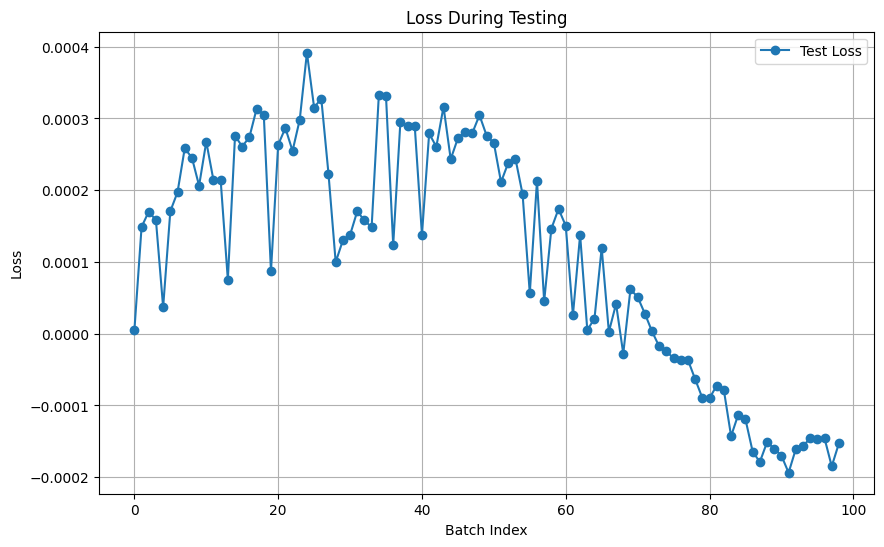

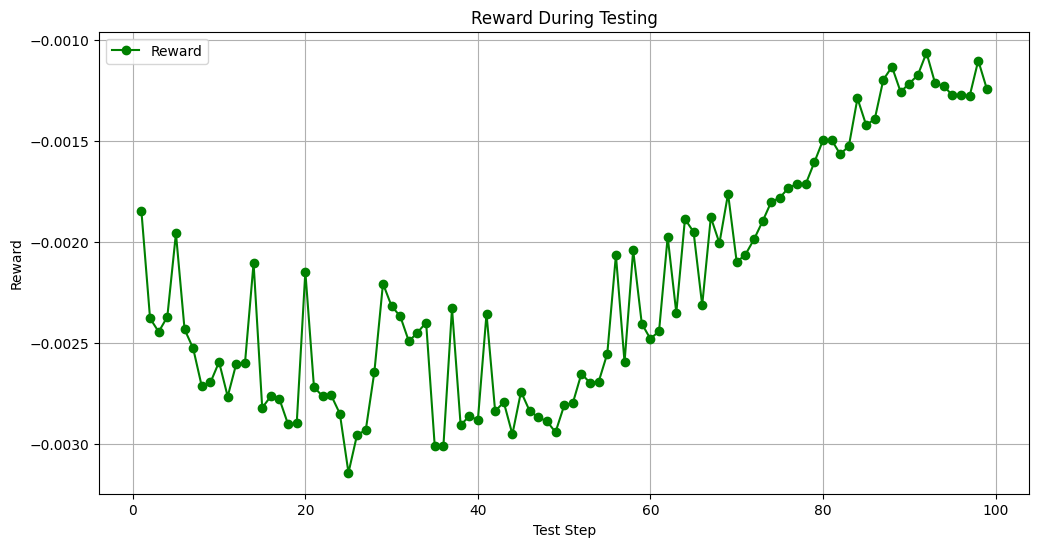

In [5]:
# Plotta la loss durante il test
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_losses)), test_losses, marker='o', label='Test Loss')
plt.title('Loss During Testing')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Grafico del reward
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(test_rewards) + 1), test_rewards, label='Reward', marker='o', color='green')
plt.title('Reward During Testing')
plt.xlabel('Test Step')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Modello Decoder
decoder = Decoder()

# Carica i pesi salvati
decoder.load_state_dict(torch.load('decoder.pth'))

decoder.eval()  # Usa l'encoder pre-addestrato

Decoder(
  (up1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

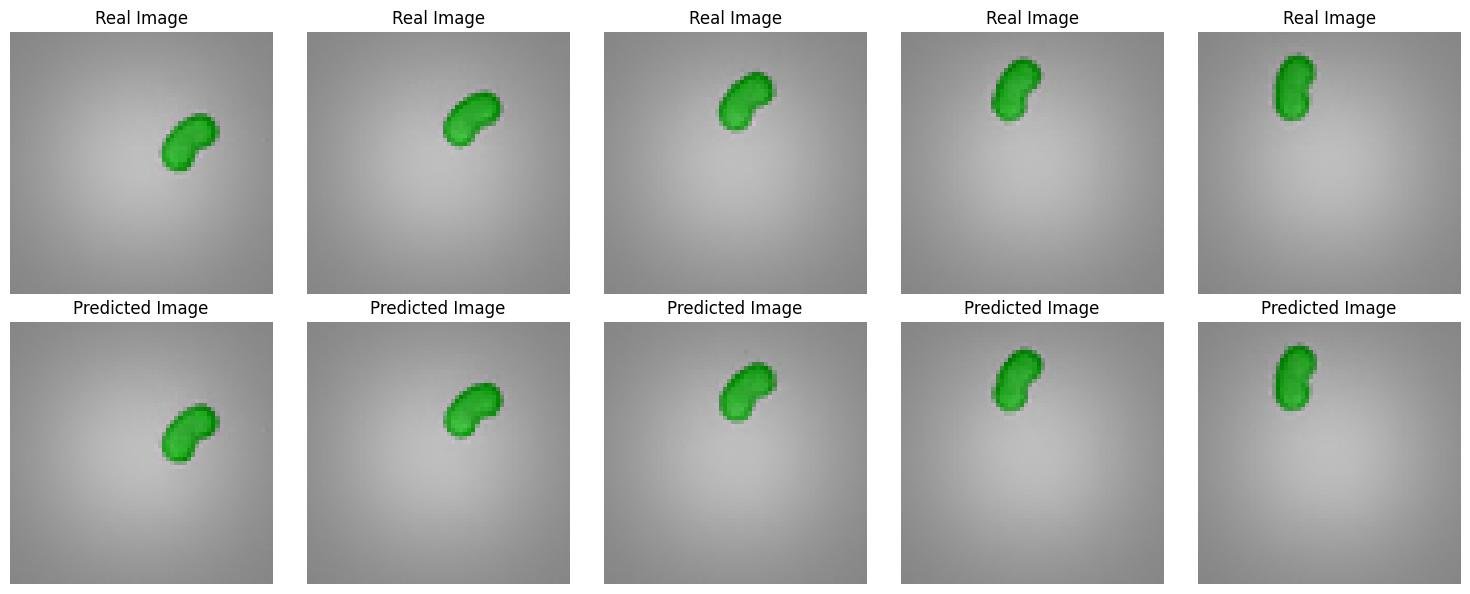

In [7]:
# Visualizza 5 esempi di stati reali e predetti, decodificati dal decoder
plt.figure(figsize=(15, 6))
#print("Real States List: ", real_states_list)
#print(len(real_states_list), len(predicted_states_list))
num_examples = min(len(real_states_list), len(predicted_states_list), 5)  # Limita il numero di esempi

for i in range(num_examples):
    
    real_state = torch.tensor(real_states_list[i]).float()  # (1, 8192)
    real_state = real_state.view(1, 128, 8, 8)
    real_image = decoder(real_state).detach().squeeze(0).permute(1, 2, 0).cpu().numpy()
    real_image = (real_image * 255).astype('uint8')

    # Decodifica lo stato predetto
    predicted_state = torch.tensor(predicted_states_list[i]).float() # (1, 8192)
    predicted_state = predicted_state.view(1, 128, 8, 8)
    predicted_image = decoder(predicted_state).detach().squeeze(0).permute(1, 2, 0).cpu().numpy()
    predicted_image = (predicted_image * 255).astype('uint8')  # Rimuove la normalizzazione per visualizzazione

    # Plotta l'immagine reale
    plt.subplot(2, 5, i + 1)
    plt.imshow(real_image)
    plt.title("Real Image")
    plt.axis('off')

    # Plotta l'immagine predetta
    plt.subplot(2, 5, i + 6)
    plt.imshow(predicted_image)
    plt.title("Predicted Image")
    plt.axis('off')

plt.tight_layout()
plt.show()
